# Aufgabe 1: Hough-Transformation für Geraden
Zur Detektion parametrisch beschreibbarer Objekte in Kantenbildern kann die *Hough-Transformation* verwendet werden.
Als *Hough-Akkumulator* wird dazu im Folgenden ein diskretisierter Parameterraum bezeichnet.

1. Bei der *Geradendetektion* wird hierfür sinnvoller Weise die *Polardarstellung* gewählt. Dabei wird eine Gerade durch ihren Normalenwinkel $\varphi$ und dem Abstand $r$ zum Ursprung beschrieben, wie in untenstehender Abbildung angedeutet. Für jeden Punkt $\boldsymbol{p}=(x,y)$ im Kantenbild wird dann für alle Winkel $\varphi$ der Parameter \begin{align}r = x \cos \varphi + y \sin \varphi\end{align} einer Geraden durch diesen Kantenpunkt bestimmt. Die Einträge an den entsprechenden Stellen $(\varphi, r)$ im Hough-Akkumulator werden inkrementiert. Lokale Maxima beschreiben letztendlich diejenigen Parameterkombinationen, die Geraden im Bild darstellen, auf denen viele Kantenpunkte liegen.


2. Implementieren Sie eine Python-Funktion, welche in einem gegebenen Kantenbild die ersten $n=50$ Geraden detektiert und stellen Sie diese dar! Stellen Sie sicher, dass die einzelnen Parameter leicht verändert werden können! Visualisieren Sie ebenfalls den Hough-Akkumulator und zeigen Sie die Zusammenhänge zum Detektionsergebnis! Welchen Einfluss hat die Wahl der Größen für die Diskretisierungsschritte auf das Ergebnis?


3. Das vorgestellte Verfahren weist einige Schwächen auf, welche durch einfache Erweiterungen abgeschwächt werden können. So können die konkreten Kantenstärken beim Inkrementieren der Akkumulatorzellen berücksichtigt werden. Darüber hinaus würde eine Glättung des Akkumulators zu eindeutigen, unverrauschten Maxima führen.

Erweitern Sie Ihre Routine derart, dass sie robust gegenüber Ausreißern und Fehldetektionen wird!

![Parametrisierung einer Geraden über ihren Normalenwinkel $\varphi$ und ihren Abstand $r$ zum Ursprung.](figures/hough.svg)


## 0. Pfade, Pakete etc.

In [1]:
import glob
import urllib.request

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import imageio
import numpy as np
import math

import skimage.filters
import skimage.feature
from skimage.transform import resize

In [2]:
image_filter = './../material/Bilder/Hough.jpg'

## 1. Definition der Parameter
Zuerst wird die mögliche Anzahl der Geraden $n$ definiert:

In [3]:
n = 50

Zusätzlich wird die Auflösung bzw. Größe des Hough-Akkumulators in Richtung $r$ und $\varphi$ festgelegt:

In [4]:
r_size = 250
phi_size = 90.0

## 2. Laden des Bildes

In [5]:
image_path = np.random.choice(glob.glob(image_filter))
image = imageio.imread(image_path)
image = resize(image, (150, 150))

/Users/Oana/python_virtual_envs/rs1_virtualenv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/Oana/python_virtual_envs/rs1_virtualenv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Für diese Aufgabe ist es wichtig, das Bild im Fließkommaformat vorliegen zu haben. Andernfalls kann der Median nicht immer korrekt berechet werden. Konvertieren sie `image` zu einer geeigneten Repräsentation:

In [6]:
image_max = np.float32(np.max(image))
image_min = np.float32(np.min(image))
image = (np.float32(image) - image_min)/(image_max - image_min)

## 3. Kantenbild ermitteln
Die Hough-Transformation ist auf Kantenbilder anzuwenden. Um ein Kantenbild zu erhalten, verwenden Sie z.B. einen Sobel-Filter aus dem Paket `scikit-image`.

In [7]:
edge_image = skimage.filters.sobel(image)

Visualisieren Sie nun das Kantenbild:

<IPython.core.display.Javascript object>


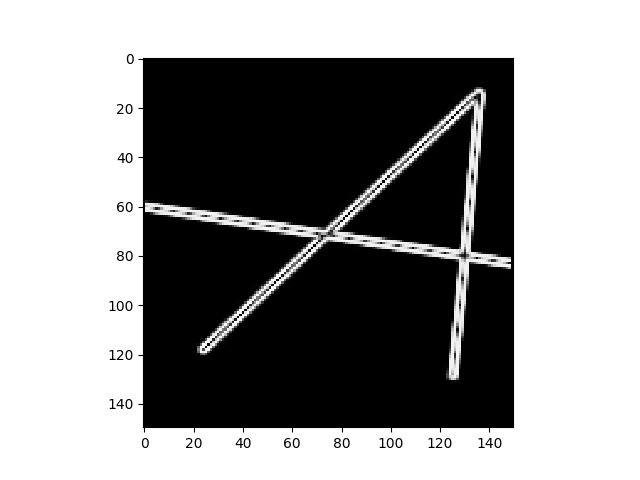

In [8]:
plt.figure()
plt.imshow(edge_image, cmap='gray')

In [9]:
thresholded_edge_image = np.copy(edge_image)
edge_image_max = np.max(edge_image)
grad_threshold = 0.7 * edge_image_max

threshold_indices = thresholded_edge_image < grad_threshold
thresholded_edge_image[threshold_indices] = 0.0

<IPython.core.display.Javascript object>


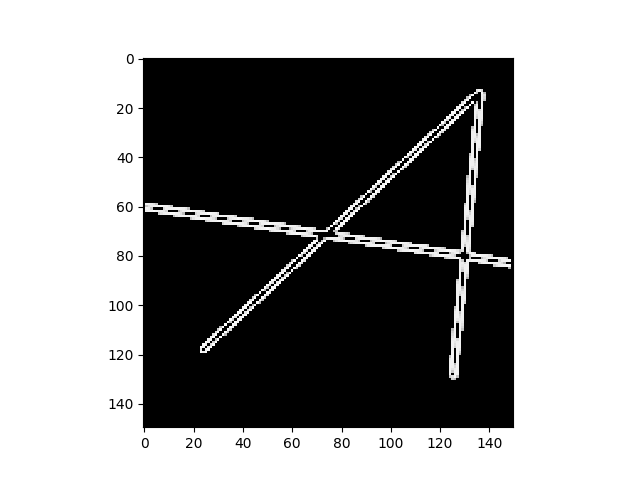

In [10]:
plt.figure()
plt.imshow(thresholded_edge_image, cmap='gray')

## 4. Hough-Transformation
Zunächst soll eine Funktion `ex5_hough_transform` definiert werden, die die Hough-Transformation durchführt und den Akkumulator sowie dessen Grenzwerte zurückliefert:

In [11]:
def ex5_hough_transform(edge_image):
    acc = np.zeros(shape=(r_size * 2, int(phi_size) * 2), dtype=np.float32)
    epsilon = 0.00001
    
    rhos = np.linspace(0, -r_size, r_size-1)
    phis = np.deg2rad(np.arange(-phi_size, phi_size, 1))
    
    cos_phis = np.cos(phis)
    sin_phis = np.sin(phis)
    
    for j in range(0, edge_image.shape[1]):
        for i in range(0, edge_image.shape[0]):
            if (edge_image[i, j] > 0.0 + epsilon):
                for phi_idx in range(1, len(phis)):
                    # add r_size for positive indexing
                    r = int(i * cos_phis[phi_idx] + j * sin_phis[phi_idx]) + r_size
                    acc[r, phi_idx] += 1
                        
    rmin = -r_size
    rmax = r_size
    phimin = -phi_size
    phimax = phi_size
    
    return acc, (rmin, rmax, phimin, phimax)

Der Hough-Akkumulator und dessen Grenzwerte werden jetzt ausgerechnet.

In [12]:
accumulator, limits = ex5_hough_transform(thresholded_edge_image)

<IPython.core.display.Javascript object>


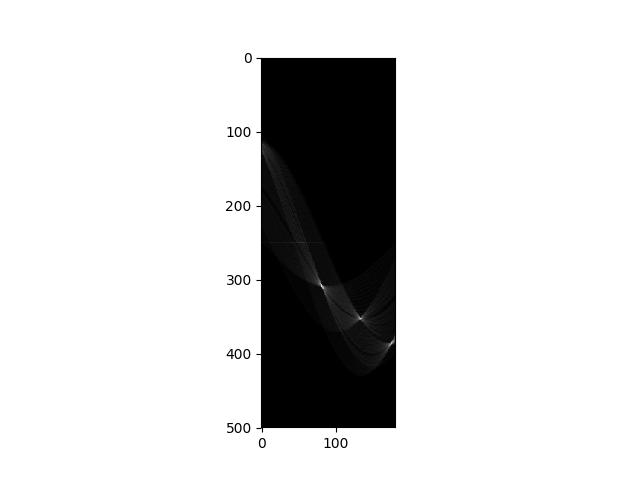

In [13]:
plt.figure()
plt.imshow(accumulator, cmap='gray')

Smooth accumulator with Gauss filter

In [14]:
accumulator = skimage.filters.gaussian(accumulator, sigma=5)

Als Sanity-Check wird der Hough-Akkumulator visualisiert:

<IPython.core.display.Javascript object>


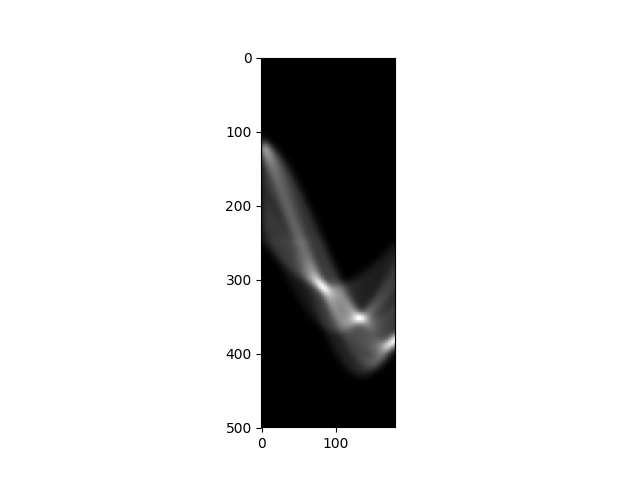

In [15]:
plt.figure()
plt.imshow(accumulator, cmap='gray')

## 5. Geradendetektion
Definieren Sie nun eine Funktion `ex5_detect_lines`, die aus einem gegebenen Hough-Akkumulator und dessen Grenzwerten die gewünschte Anzahl Geraden als Liste von $(r,\varphi,s)$-Tupeln zurückgibt, wobei $s$ die Stärke der Gerade bezeichnet.

In [16]:
def ex5_detect_lines(acc, limits):
    a = np.copy(acc)
    rmin, rmax, phimin, phimax = limits
    lines = []
    phis = np.deg2rad(np.arange(phimin, phimax, 1))
    
    for i in range(0, n):
        curr_max_acc_idx = np.unravel_index(a.argmax(), a.shape)
        # add to lines (i, j, acc_value)
        r_idx = curr_max_acc_idx[0]
        r = r_idx - np.abs(rmin)
        phi_idx = curr_max_acc_idx[1]
        phi = phis[phi_idx]
        lines.append((r, phi, a[r_idx, phi_idx]))
        a[r_idx, phi_idx] = 0
    
    return lines

Die soeben definierte Funktion wird nun aufgerufen, um den Akkumulator zu verarbeiten:

In [17]:
lines = ex5_detect_lines(accumulator, limits)

Anschließend werden die Geraden visualisiert. Tipp: die `plot`-Funktion von Matplotlib kann Strecken durch Aufruf von `plt.plot([x0, x1], [y0, y1])` zeichnen.

In [18]:
def point_within_bounds(image_shape, point):
    x = point[0]
    y = point[1]
    if (x >= 0 and x <= image_shape[0] and y >= 0 and y <= image_shape[1]): return True
    else: return False

<IPython.core.display.Javascript object>


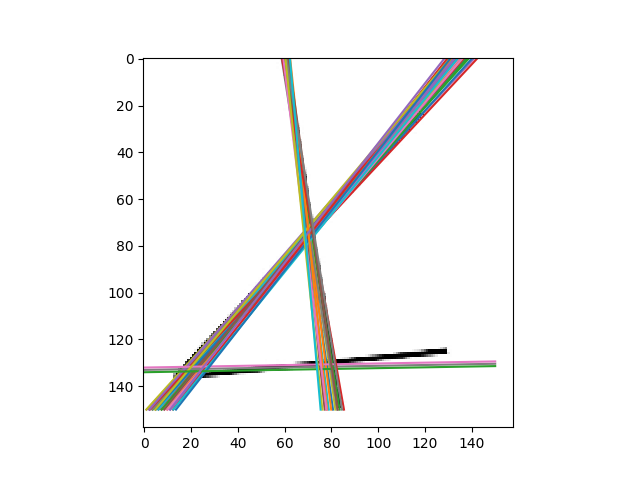

(0, 152.4366080861901) (150, -14.155269138188828)
(0, 155.47381484399307) (150, -17.081446239158367)
(0, 153.9310846360547) (150, -12.660792588324227)
(0, 156.99806793069888) (150, -15.557193152452555)
(0, 149.56047693524175) (150, -11.294829568460642)
(0, 151.02675612088137) (150, -9.828550382821021)
(0, 158.68383033976207) (150, -20.07920854936947)
(0, 160.2395541666225) (150, -18.52348472250904)
(0, 153.94956175728723) (150, -18.605699325864208)
(0, 150.94213153632546) (150, -15.649745688053457)
(0, 148.2743235814498) (150, -7.055223487135635)
(0, 146.83476704182408) (150, -8.494780026761362)
(0, 157.12810651290167) (150, -21.63493237622987)
(0, 155.4255611859193) (150, -11.166316038459627)
(0, 148.09419774960213) (150, -12.761108754100263)
(0, 162.07960436470646) (150, -23.154969115551268)
(0, 158.5223210174047) (150, -14.032940065746743)
(0, 152.493035306521) (150, -8.3622711971814)
(0, 163.6686200937722) (150, -21.565953386485518)
(0, 160.4905886356407) (150, -24.743984844617017)

In [21]:
plt.figure()
plt.imshow(np.transpose(image), cmap='gray', shape=edge_image.shape)
for r, phi, acc_val in lines:
    a = - np.cos(phi) / np.sin(phi)
    b = r / np.sin(phi)
    
    left = (0, b)
    right = (edge_image.shape[0], edge_image.shape[0] * a + b)
    print(left, right)
    if (point_within_bounds(edge_image.shape, left) and point_within_bounds(edge_image.shape, right)):
        plt.plot((left[0], right[0]), (left[1], right[1]))
    else:
        a = - np.sin(phi) / np.cos(phi)
        b = r / np.cos(phi)
        top = (b, 0)
        bottom = (edge_image.shape[1] * a + b, edge_image.shape[1])
        if (point_within_bounds(edge_image.shape, top) and point_within_bounds(edge_image.shape, bottom)):
            plt.plot((top[0], bottom[0]), (top[1], bottom[1]))
    